项目要求：<br>
1.新建毕业notebook项目文档，命名为姓名全拼-final，并放至于http://sxy.julyedu.com:8001/tree/0.Teacher/Exam/Final/学员姓名全拼目录中/，<br>
2.注册kaggle，并阅读项目详情<br>
2.分析，理顺，项目要求并落实在文档中。20分<br>
4.进行载入数据，清洗，建模，训练，预测等流程，并对相应步骤（及思想）进行说明并落实在文档中 50分<br>
4.在kaggle完成至少两次或以上提交。记录成绩，分析成绩差异的原因。并落实在文档中。20<br>
5.项目总结。对该项目做最后总结，可以是心得，也可以是教训。 并落实在文档中。10分<br>
6.如在项目文档中参考引用了其它kernel。额外10分（但总分不超过100分）<br>

完成时间：<br>
2018年4月15号前。<br>

该文件主要是熟悉数据<br>

## 引入包

In [220]:
import pandas as pd
import numpy as np

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [222]:
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm

## 一、读入数据

In [223]:
train = pd.read_csv('data/train.csv', header=0)
test = pd.read_csv('data/test.csv', header=0)

## 二、查看数据状态

### 1、基础信息

In [224]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [225]:
train.shape

(1460, 81)

In [226]:
field_properties = pd.read_excel('data/data_info.xlsx', header=0, sheetname='FieldsInfo')
field_properties.head()

,Data fields,data description,comment
0,SalePrice,the property's sale price in dollars. This is ...,售价
1,MSSubClass,The building class,建筑类型（数字类型，需要独热向量） 测试集比训练集合多一类
2,MSZoning,The general zoning classification,一般的区域分类（类别型，5类）
3,LotFrontage,Linear feet of street connected to property,到街道的直线距离（使用均值填上之后 平均为 70） 空： 259\n测试集 （使用均值填上之...
4,LotArea,Lot size in square feet,面积（平方英尺）


### 2、类别型数据

类别是数字表示的字段 MSSubClass/OverallQual/OverallCond

In [227]:
columns_num_class = ['MSSubClass', 'OverallQual', 'OverallCond']

for cols in columns_num_class:
    train[cols] = train[cols].astype(str)
    test[cols] = test[cols].astype(str)

### 3、列缺失值对比

In [228]:
info_data = pd.read_excel('data/data_info.xlsx', header=0,sheetname='Train-VS-Test_NullCols')
info_data['train_null_num'] = train.shape[0] - info_data['train_total']
info_data['test_null_num'] = test.shape[0] - info_data['test_total']

In [229]:
# 挑选缺失值都很多的列
rule_and = ((info_data['train_null_num'] >1000) & (info_data['test_null_num'] >1000))
data1 = info_data.loc[rule_and, :]
# rule_or = ((info_data['train_null_num'] >1000) & (info_data['test_null_num'] >1000))
data1

,columns,train_data,test_data,train_total,test_total,train_null_num,test_null_num
6,Alley,91 non-null object,107 non-null object,91,107.0,1369,1352.0
72,PoolQC,7 non-null object,3 non-null object,7,3.0,1453,1456.0
73,Fence,281 non-null object,290 non-null object,281,290.0,1179,1169.0
74,MiscFeature,54 non-null object,51 non-null object,54,51.0,1406,1408.0


In [230]:
# 挑选其中一个列缺失值比较多
rule_or = ((info_data['train_null_num'] >1000) | (info_data['test_null_num'] >1000))
data2 = info_data.loc[rule_or, :]
data2

,columns,train_data,test_data,train_total,test_total,train_null_num,test_null_num
6,Alley,91 non-null object,107 non-null object,91,107.0,1369,1352.0
72,PoolQC,7 non-null object,3 non-null object,7,3.0,1453,1456.0
73,Fence,281 non-null object,290 non-null object,281,290.0,1179,1169.0
74,MiscFeature,54 non-null object,51 non-null object,54,51.0,1406,1408.0


** 结论：删除列,需要删除列Alley,PoolQC,Fence,MiscFeature **

In [231]:
# drop_list = ['Alley','PoolQC','Fence','MiscFeature']

In [232]:
# train.drop(drop_list, axis=1, inplace=True)
# test.drop(drop_list, axis=1, inplace=True)

** 直接使用缺失值的统计查看一下 **

In [233]:
# 将测试数据和训练数据进行拼接，一起进行处理(不包含 Id 和 SalePrice)

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']), axis=0,ignore_index=True)
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [234]:
# 查看定性数据和定量数据
quantitative = [f for f in all_data.columns if all_data.dtypes[f] != 'object']
qualitative = [f for f in all_data.columns if all_data.dtypes[f] == 'object']

print('quantitative(数字型): {} , qualitative(类别型): {}'.format(len(quantitative), len(qualitative)))

quantitative(数字型): 33 , qualitative(类别型): 46


In [235]:
missing = all_data.isnull().sum()

In [236]:
missing.sort_values(inplace=True,ascending=False)
missing = missing[missing>0]
missing

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
BsmtUnfSF          1
TotalBsmtSF        1
Exterior1st        1
SaleType           1
Electrical         1
KitchenQual        1
GarageArea         1
GarageCars         1
dtype: int64

In [237]:
types = all_data[missing.index].dtypes

In [238]:
percent = (missing/all_data.shape[0])
percent

PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
FireplaceQu     0.486468
LotFrontage     0.166495
GarageCond      0.054471
GarageQual      0.054471
GarageYrBlt     0.054471
GarageFinish    0.054471
GarageType      0.053786
BsmtCond        0.028092
BsmtExposure    0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrType      0.008222
MasVnrArea      0.007879
MSZoning        0.001370
BsmtHalfBath    0.000685
Utilities       0.000685
Functional      0.000685
BsmtFullBath    0.000685
BsmtFinSF2      0.000343
BsmtFinSF1      0.000343
Exterior2nd     0.000343
BsmtUnfSF       0.000343
TotalBsmtSF     0.000343
Exterior1st     0.000343
SaleType        0.000343
Electrical      0.000343
KitchenQual     0.000343
GarageArea      0.000343
GarageCars      0.000343
dtype: float64

In [239]:
miss_percent = pd.concat([missing, percent, types], axis=1, keys = ['Total', 'percent', 'Types'])
miss_percent

,Total,percent,Types
PoolQC,2909,0.996574,object
MiscFeature,2814,0.964029,object
Alley,2721,0.932169,object
Fence,2348,0.804385,object
FireplaceQu,1420,0.486468,object
LotFrontage,486,0.166495,float64
GarageCond,159,0.054471,object
GarageQual,159,0.054471,object
GarageYrBlt,159,0.054471,float64
GarageFinish,159,0.054471,object


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 <a list of 34 Text xticklabel objects>)

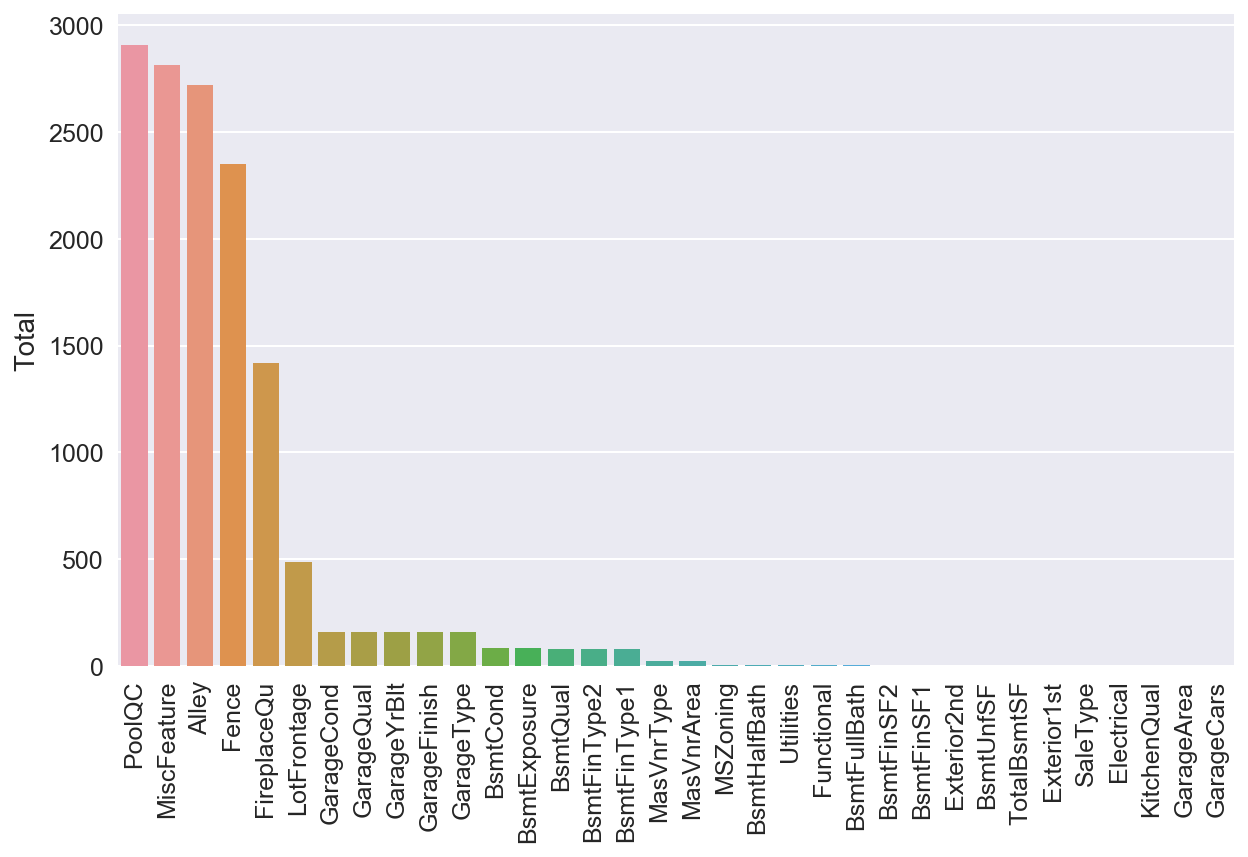

In [240]:
_, ax = plt.subplots(figsize = (10,6))
sns.barplot(data=miss_percent, x=miss_percent.index, y='Total', ax=ax)
# 横坐标翻转
plt.xticks(rotation=90)

### 4、行缺失值对比

In [290]:
n_null = (all_data==np.nan).sum(axis=1)
n_null.value_counts()

0    2919
dtype: int64

### 5、统计值

In [241]:
train.describe()['SalePrice']

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [242]:
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())
# 在统计学中，峰度（Kurtosis）衡量实数随机变量概率分布的峰态。峰度高就意味着方差增大是由低频度的大于或小于平均值的极端差值引起的。


Skewness: 1.882876
Kurtosis: 6.536282


### 原始特征相关性

In [243]:
corrmat = train.corr()
corrmat

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,-0.010601,-0.033226,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
LotFrontage,-0.010601,1.000000,0.426095,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,0.426095,1.000000,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
YearBuilt,-0.012713,0.123349,0.014228,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.088866,0.013788,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.193458,0.104160,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,0.233633,0.214103,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.005968,0.049900,0.111170,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,-0.209294,0.104810,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378
BsmtUnfSF,-0.007940,0.132644,-0.002618,0.149040,0.181133,0.114442,-0.495251,-0.209294,1.000000,0.415360,...,-0.005316,0.129005,-0.002538,0.020764,-0.012579,-0.035092,-0.023837,0.034888,-0.041258,0.214479
TotalBsmtSF,-0.015415,0.392075,0.260833,0.391452,0.291066,0.363936,0.522396,0.104810,0.415360,1.000000,...,0.232019,0.247264,-0.095478,0.037384,0.084489,0.126053,-0.018479,0.013196,-0.014969,0.613581


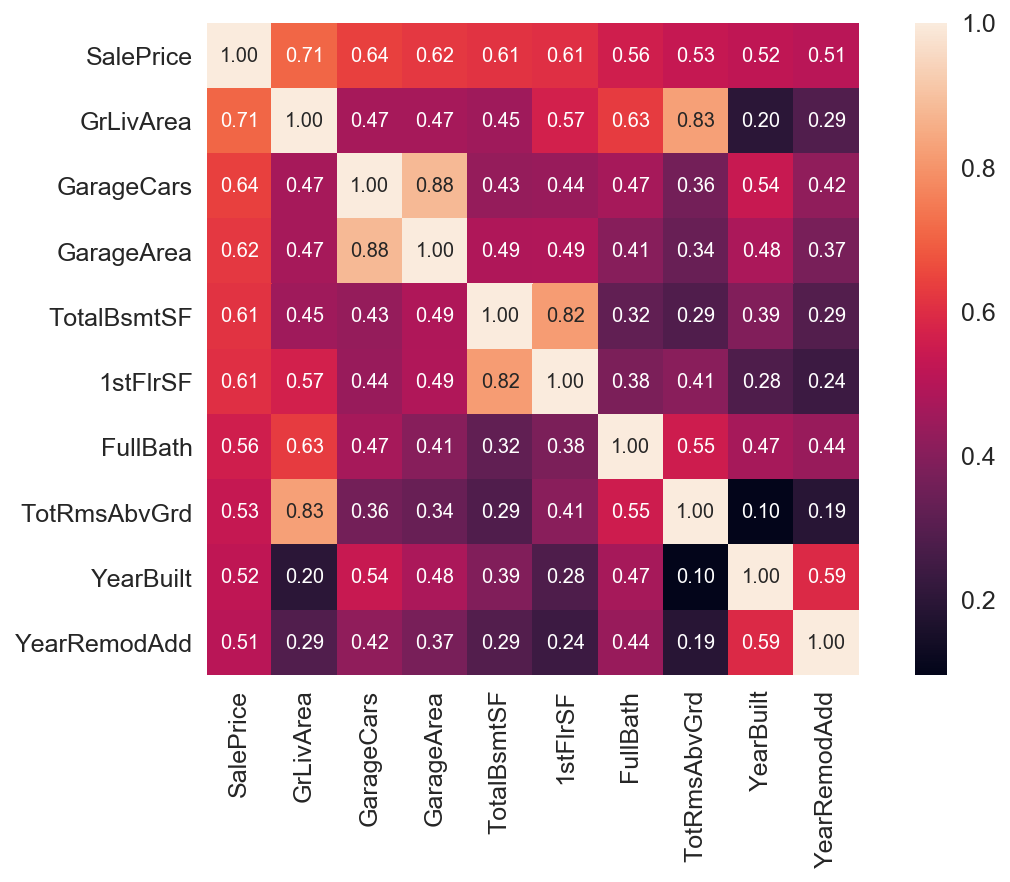

In [244]:
#saleprice correlation matrix 相关矩阵
_, ax = plt.subplots(figsize = (10,6))
k = 10 #number of variables for heatmap  选取与价格相关性最大的前k 个
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, ax=ax)
plt.show()

In [245]:
## 同时是相关性较强的列，也是缺失数据的
miss_percent.index.intersection(cols)

Index(['TotalBsmtSF', 'GarageArea', 'GarageCars'], dtype='object')

In [246]:
miss_percent.loc[miss_percent.index.intersection(cols)]

,Total,percent,Types
TotalBsmtSF,1,0.000343,float64
GarageArea,1,0.000343,float64
GarageCars,1,0.000343,float64


In [247]:
# 将缺失大于1 的列删除
miss_percent[miss_percent['Total'] > 1]

,Total,percent,Types
PoolQC,2909,0.996574,object
MiscFeature,2814,0.964029,object
Alley,2721,0.932169,object
Fence,2348,0.804385,object
FireplaceQu,1420,0.486468,object
LotFrontage,486,0.166495,float64
GarageCond,159,0.054471,object
GarageQual,159,0.054471,object
GarageYrBlt,159,0.054471,float64
GarageFinish,159,0.054471,object


In [248]:
#dealing with missing data
all_data = all_data.drop((miss_percent[miss_percent['Total'] > 1]).index,1)
all_data.isnull().sum().max() #just checking that there's no missing data missing...
# 对于missing 1 的后面使用平均数填充

1

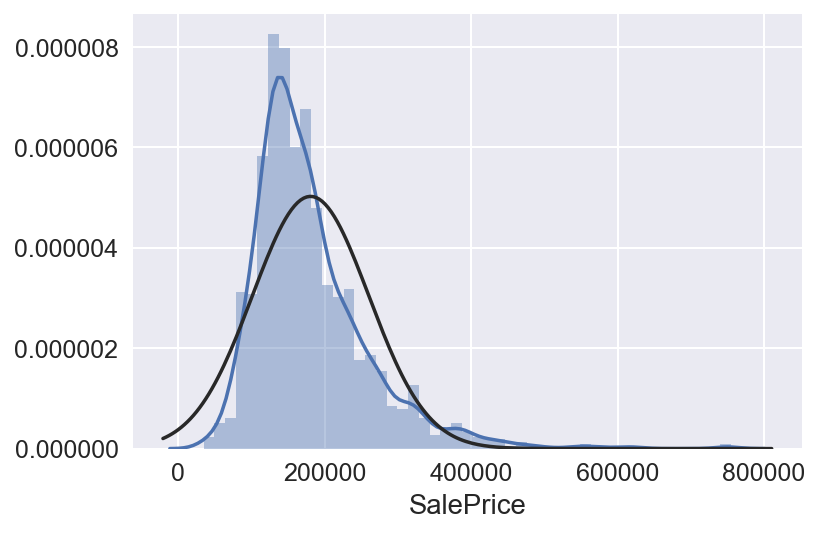

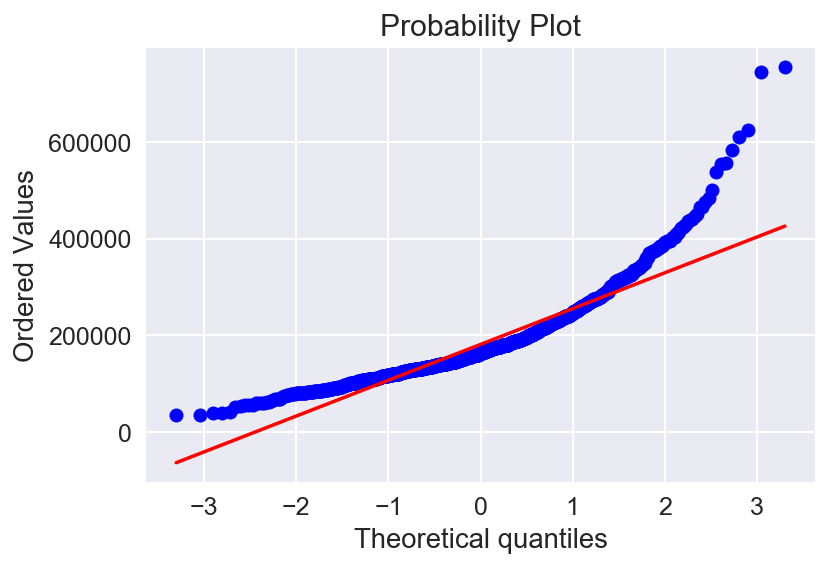

In [249]:
#histogram and normal probability plot
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

处理标签变为 log 

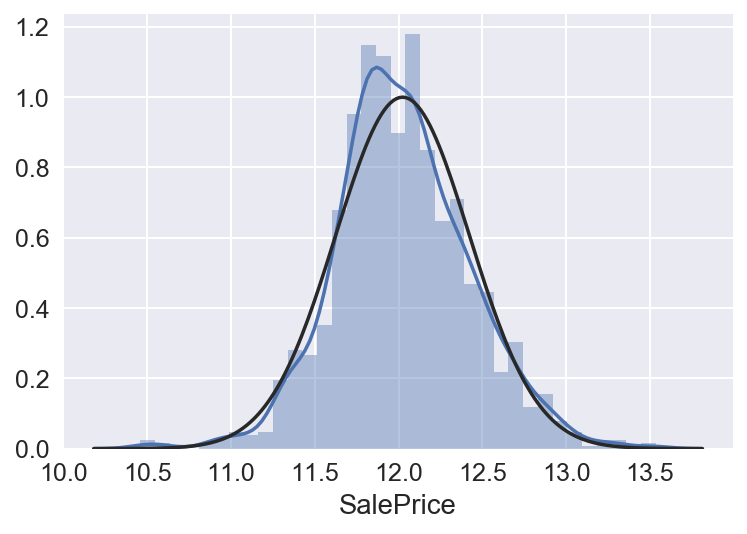

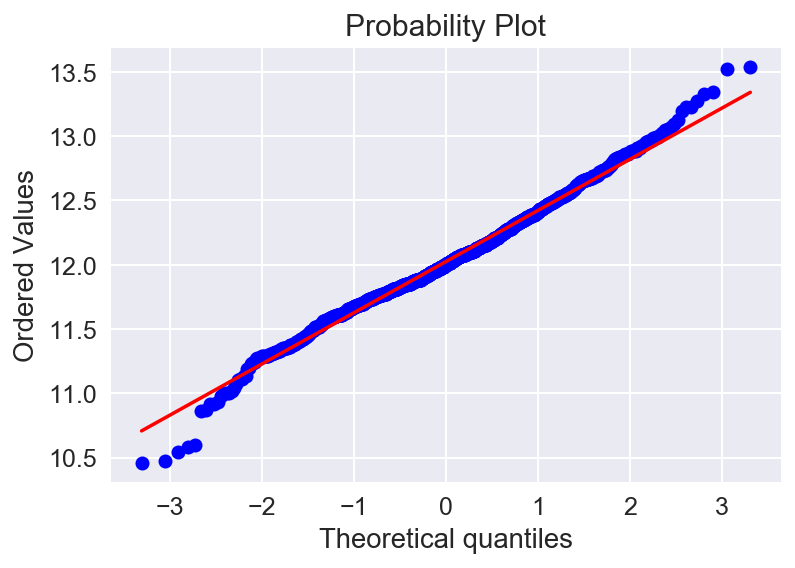

In [250]:
train['SalePrice'] = np.log(train['SalePrice'])
#histogram and normal probability plot
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
# log 之后更符合正态分布

In [251]:
quantitative = [f for f in all_data.columns if all_data.dtypes[f] != 'object']
qualitative = [f for f in all_data.columns if all_data.dtypes[f] == 'object']
print("quantitative: {}, qualitative: {}" .format (len(quantitative),len(qualitative)))


quantitative: 28, qualitative: 28


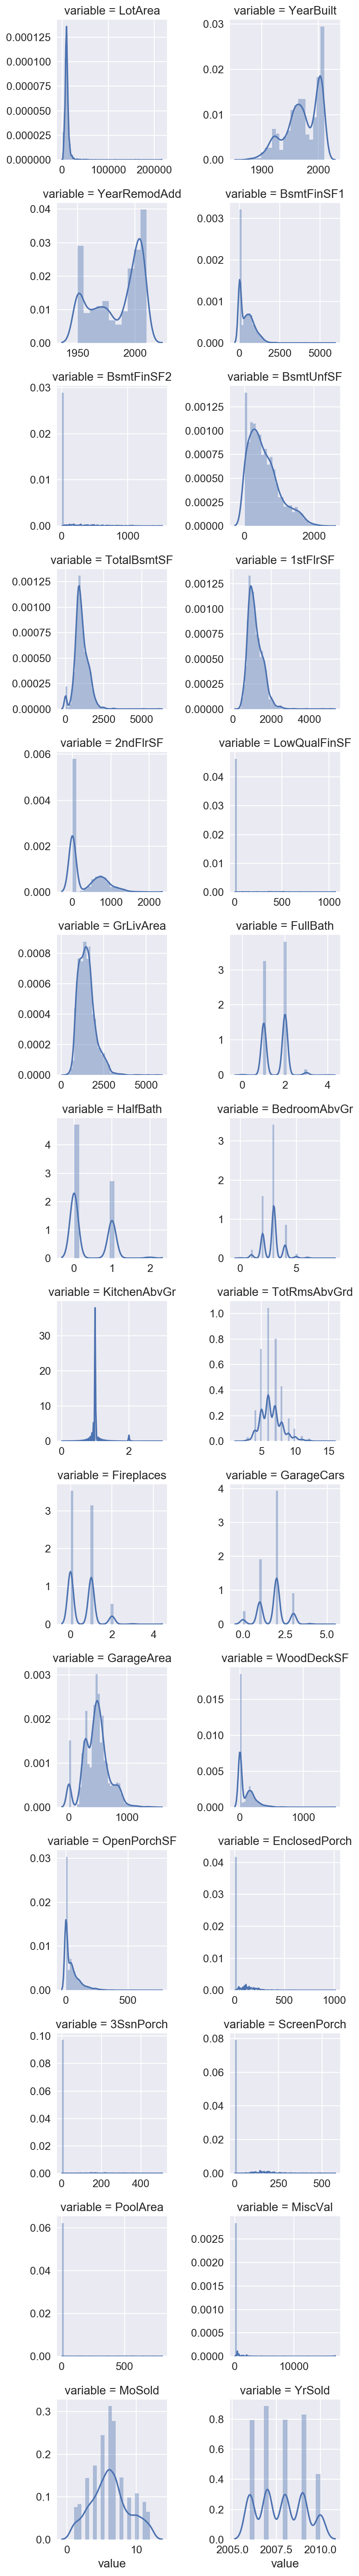

In [252]:
f = pd.melt(all_data, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")


上面有些数据是类似于正态分布的，我们可以对其进行log操作了提升质量的，有些则不适合，合适的预选对象有LotArea,BsmtUnfSF,1stFlrSF,TotalBsmtSF,KitchenAbvGr

In [253]:
all_data[quantitative].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.145323
EnclosedPorch     4.003891
ScreenPorch       3.946694
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
BsmtFinSF1        1.424989
GrLivArea         1.269358
TotalBsmtSF       1.162285
BsmtUnfSF         0.919351
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BedroomAbvGr      0.326324
GarageArea        0.241176
MoSold            0.195884
FullBath          0.167606
YrSold            0.132399
GarageCars       -0.218260
YearRemodAdd     -0.451020
YearBuilt        -0.599806
dtype: float64

### 定量特征分析

方差分析或变方分析（Analysis of variance，简称 ANOVA）为数据分析中常见的统计模型

In [254]:
train_data = all_data.loc[train.index]
train_data.shape

(1460, 56)

In [255]:
train_data['SalePrice'] = train.SalePrice

D:\BigData\Python\Install\Anaconda3\lib\site-packages\scipy\stats\stats.py:2958: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))
D:\BigData\Python\Install\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


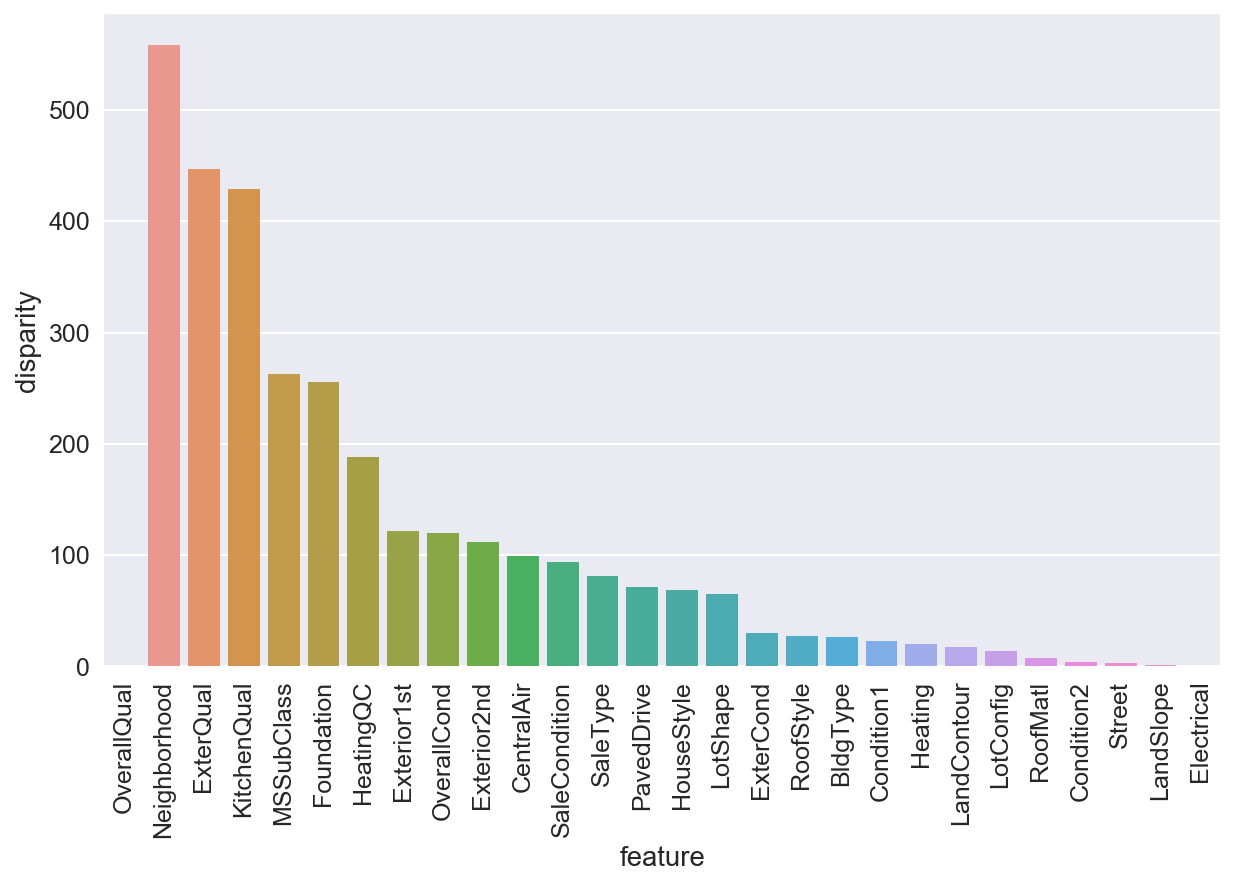

In [256]:
# 这里涉及到的是对训练集合进行查看

def anova(frame,qualitative):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')


_, ax = plt.subplots(figsize = (10,6))
a = anova(train_data,qualitative)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)


stats.f_oneway 的作用是计算这种定性变量对于SalePrice的作用，如果GarageType的每个类别SalePrice的价格方差差不多，意味着该变量对于SalePrice就没什么作用，stats.f_oneway 返回的 pval > 0.05，基本就意味着量集合的相似.
低方差的列对标签值影响不大

In [257]:
# 定性变量进行下处理，对齐进行数值编码，让他转换为定性的列,不会影响之前的列
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:
    encode(train_data, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)
# 得到所有类别特征

['MSSubClass_E', 'Street_E', 'LotShape_E', 'LandContour_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'OverallQual_E', 'OverallCond_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'PavedDrive_E', 'SaleType_E', 'SaleCondition_E']


In [265]:
train_data.head()

,MSSubClass,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,ExterCond_E,Foundation_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,PavedDrive_E,SaleType_E,SaleCondition_E
0,60,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,4.0,6.0,6.0,5.0,2.0,5.0,3.0,3.0,5.0,5.0
1,20,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,...,4.0,3.0,6.0,5.0,2.0,5.0,2.0,3.0,5.0,5.0
2,60,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,4.0,6.0,6.0,5.0,2.0,5.0,3.0,3.0,5.0,5.0
3,70,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,...,4.0,2.0,6.0,4.0,2.0,5.0,3.0,3.0,5.0,2.0
4,60,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,...,4.0,6.0,6.0,5.0,2.0,5.0,3.0,3.0,5.0,5.0


In [258]:
# 选出了包含缺失数据的行，处理一下
missing_data = all_data.isnull().sum()
missing_data = missing_data[missing_data>0]
ids = all_data[missing_data.index].isnull()
# index (0), columns (1)
all_data.loc[ids[ids.any(axis=1)].index][missing_data.index]


,Exterior1st,Exterior2nd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Electrical,KitchenQual,GarageCars,GarageArea,SaleType
1379,VinylSd,VinylSd,0.0,0.0,384.0,384.0,NaN,Gd,2.0,400.0,WD
1555,Wd Sdng,Wd Sdng,0.0,0.0,689.0,689.0,SBrkr,NaN,1.0,180.0,COD
2120,MetalSd,CBlock,NaN,NaN,NaN,NaN,FuseA,TA,1.0,280.0,ConLD
2151,NaN,NaN,1035.0,0.0,545.0,1580.0,SBrkr,Fa,0.0,0.0,WD
2489,Plywood,Plywood,190.0,873.0,95.0,1158.0,SBrkr,TA,1.0,303.0,NaN
2576,Wd Sdng,Plywood,548.0,0.0,311.0,859.0,SBrkr,Gd,NaN,NaN,WD


In [259]:
# 处理完后对于nan的数据，其值还是nan
train_data.loc[1379,'Electrical_E']

nan

### 定性编码后相关性

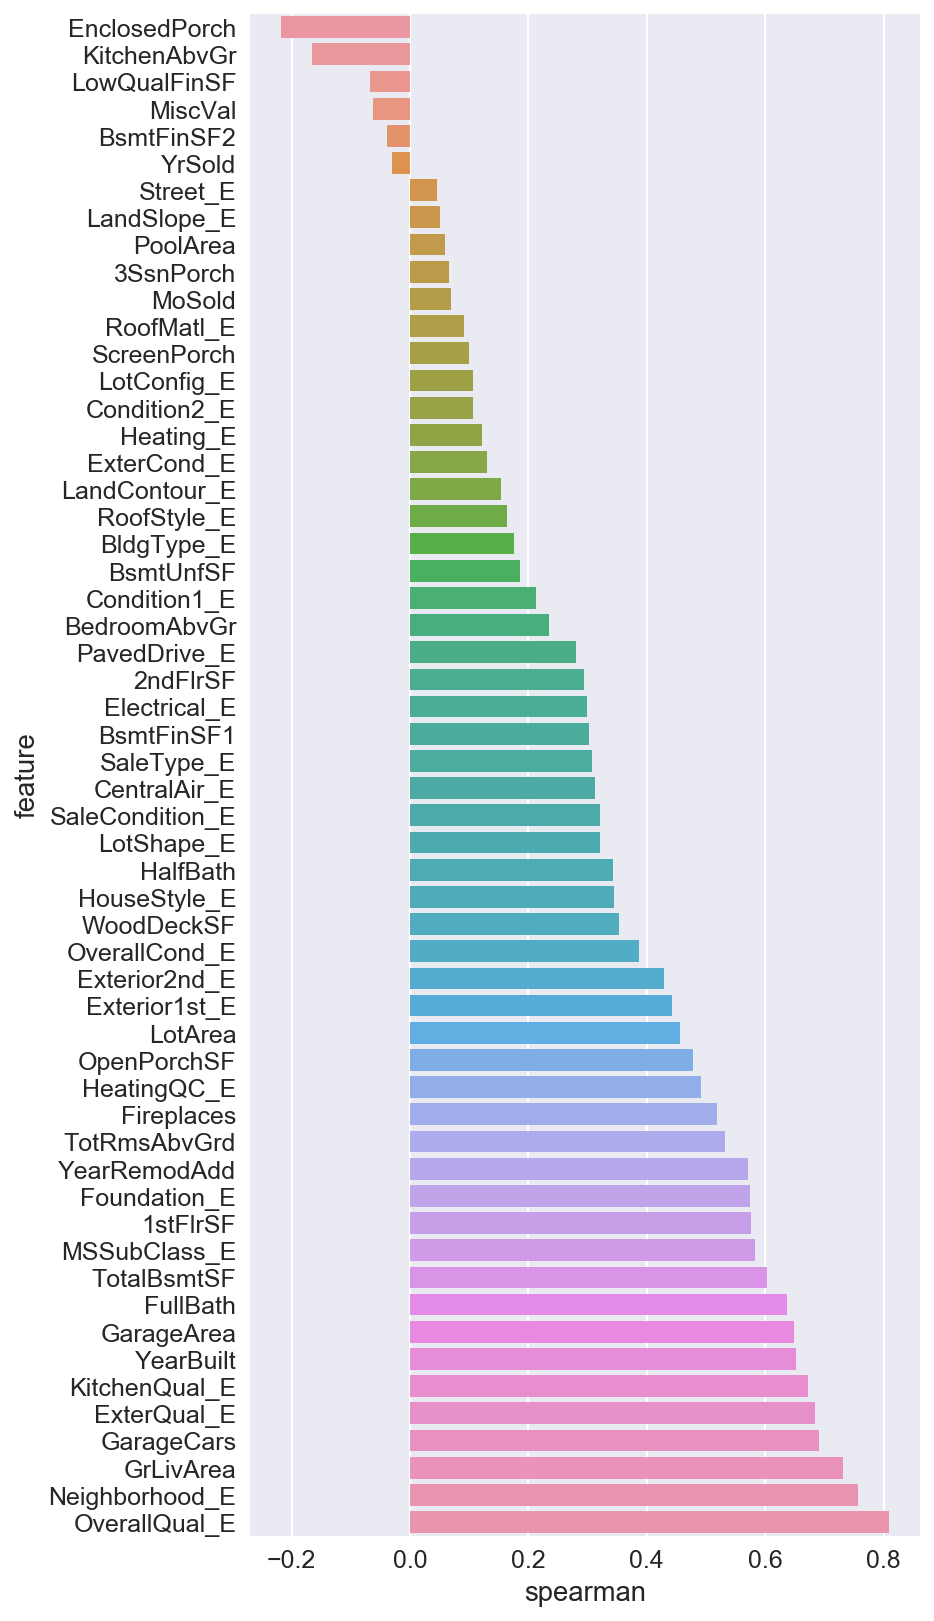

In [261]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    #Signature: a.corr(other, method='pearson', min_periods=None)
    #Docstring:
    #Compute correlation with `other` Series, excluding missing values
    # 计算特征和 SalePrice的 斯皮尔曼 相关系数
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features))) # width, height
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
spearman(train_data, features)


特征 OverallQual Neighborhood GrLiveArea 对价格影响都比较大<br>
下面我们分析下特征列之间的相关性，如果两特征相关，在做回归的时候会导致共线性问题

In [276]:
help(fig.tight_layout)

Help on method tight_layout in module matplotlib.figure:

tight_layout(renderer=None, pad=1.08, h_pad=None, w_pad=None, rect=None) method of matplotlib.figure.Figure instance
    Adjust subplot parameters to give specified padding.
    
    Parameters:
    
      pad : float
        padding between the figure edge and the edges of subplots,
        as a fraction of the font-size.
      h_pad, w_pad : float
        padding (height/width) between edges of adjacent subplots.
        Defaults to `pad_inches`.
      rect : if rect is given, it is interpreted as a rectangle
        (left, bottom, right, top) in the normalized figure
        coordinate that the whole subplots area (including
        labels) will fit into. Default is (0, 0, 1, 1).



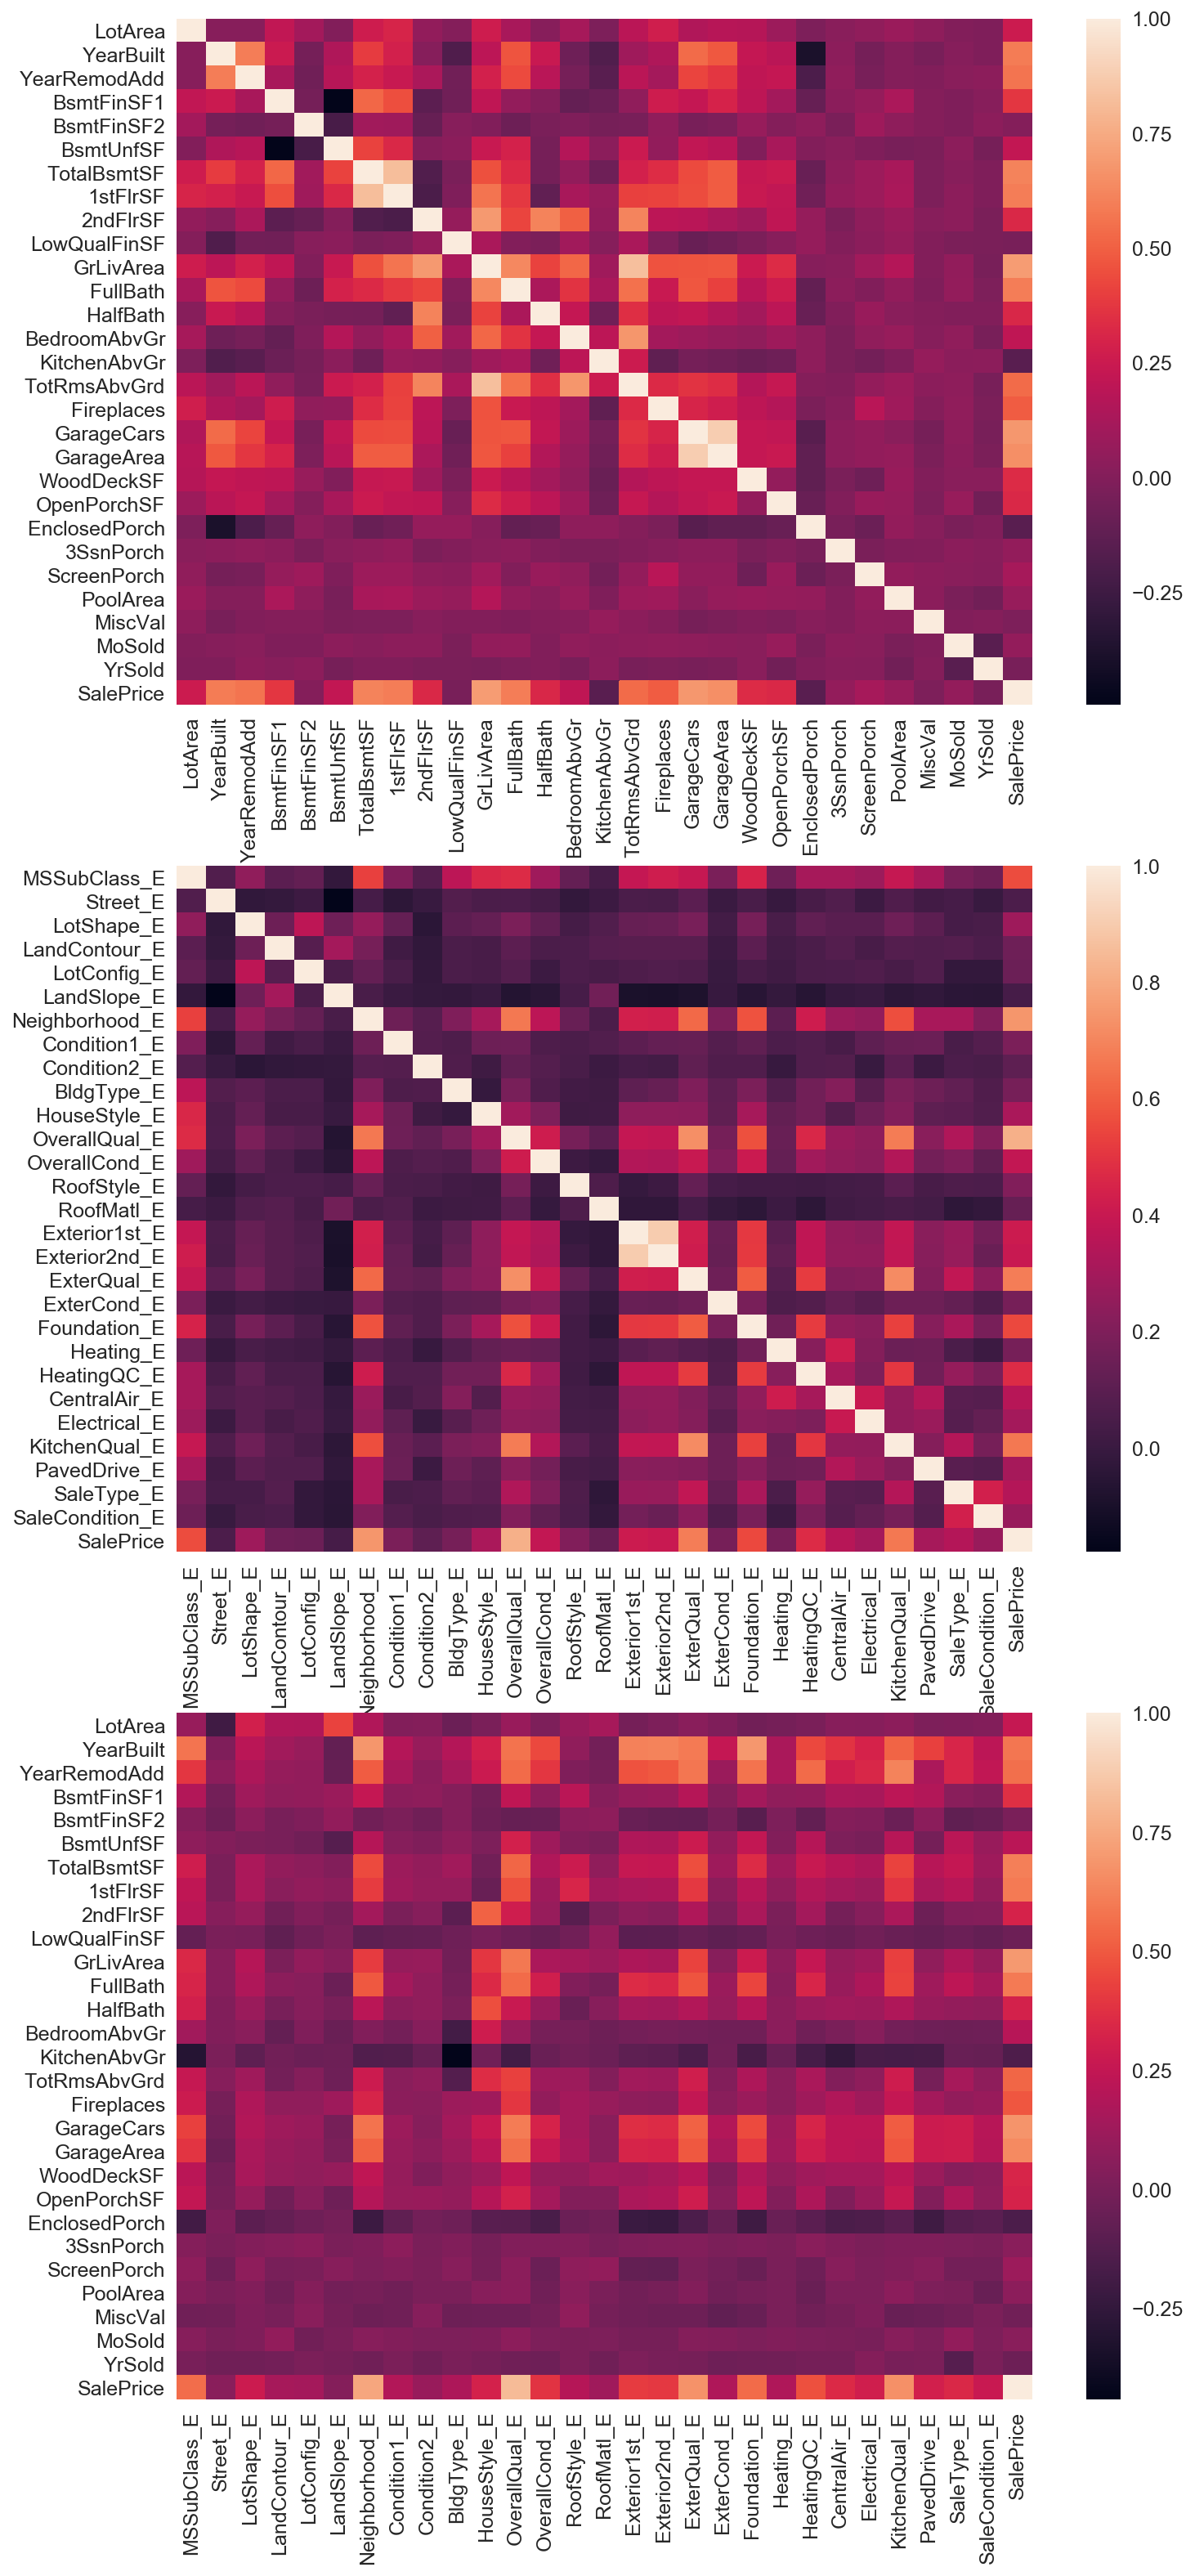

In [277]:
# 数值型相关
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3,figsize = (10,21))
fig.tight_layout(h_pad=5)
corr = train_data[quantitative+['SalePrice']].corr()
sns.heatmap(corr, ax=ax1)
# 定性编码后特征相关性
corr = train_data[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr,ax=ax2)
# [31,27]
# 
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = train_data[q1].corr(train_data[q2])
sns.heatmap(corr,ax=ax3)



In [278]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(train_data, id_vars=['SalePrice'], value_vars=quantitative+qual_encoded)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "SalePrice")



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## 以下是查看每列数据的状态

In [ ]:
# 删除Alley,PoolQC,Fence，MiscFeature (many null)
# 删除 Utilities (Many same values for train data,the same values for test data)

# 考虑删除PoolArea，  many valuse is 0
# 3SsnPorch/EnclosedPorch   1200 左右是0 可以考虑是否删除
# MiscVal  1400 左右为0 



In [24]:
train['MSSubClass'].value_counts().sort_index()

20     536
30      69
40       4
45      12
50     144
60     299
70      60
75      16
80      58
85      20
90      52
120     87
160     63
180     10
190     30
Name: MSSubClass, dtype: int64

In [25]:
test['MSSubClass'].value_counts().sort_index()

20     543
30      70
40       2
45       6
50     143
60     276
70      68
75       7
80      60
85      28
90      57
120     95
150      1
160     65
180      7
190     31
Name: MSSubClass, dtype: int64

In [5]:
train['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [26]:
test['MSZoning'].value_counts()

RL         1114
RM          242
FV           74
C (all)      15
RH           10
Name: MSZoning, dtype: int64

In [11]:
import numpy as np
train['LotFrontage_fill_mean'] = train['LotFrontage'].fillna(train['LotFrontage'].mean())
np.average(train['LotFrontage_fill_mean'])

70.049958368026637

In [28]:
import numpy as np
test['LotFrontage_fill_mean'] = test['LotFrontage'].fillna(test['LotFrontage'].mean())
np.average(test['LotFrontage_fill_mean'])

68.580357142857139

In [12]:
train['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [29]:
test['Street'].value_counts()

Pave    1453
Grvl       6
Name: Street, dtype: int64

In [14]:
train['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [30]:
test['Alley'].value_counts()

Grvl    70
Pave    37
Name: Alley, dtype: int64

In [ ]:
删除列

In [38]:
train.drop('Alley', axis=1, inplace=True)

In [15]:
train['LotShape'].value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

In [31]:
test['LotShape'].value_counts()

Reg    934
IR1    484
IR2     35
IR3      6
Name: LotShape, dtype: int64

In [16]:
train['LandContour'].value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

In [32]:
train['LandContour'].value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

In [18]:
train['Utilities'].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [34]:
test['Utilities'].value_counts()

AllPub    1457
Name: Utilities, dtype: int64

删除列

In [41]:
train.drop('Utilities', axis=1, inplace=True)

In [42]:
train['LotConfig'].value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

In [43]:
test['LotConfig'].value_counts()

Inside     1081
Corner      248
CulDSac      82
FR2          38
FR3          10
Name: LotConfig, dtype: int64

In [44]:
train['LandSlope'].value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

In [45]:
test['LandSlope'].value_counts()

Gtl    1396
Mod      60
Sev       3
Name: LandSlope, dtype: int64

In [46]:
train['Neighborhood'].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [47]:
test['Neighborhood'].value_counts()

NAmes      218
OldTown    126
CollgCr    117
Somerst     96
Edwards     94
NridgHt     89
Gilbert     86
Sawyer      77
SawyerW     66
Mitchel     65
NWAmes      58
IDOTRR      56
Crawfor     52
BrkSide     50
Timber      34
NoRidge     30
StoneBr     26
SWISU       23
MeadowV     20
ClearCr     16
NPkVill     14
BrDale      14
Veenker     13
Blmngtn     11
Blueste      8
Name: Neighborhood, dtype: int64

In [48]:
train['Condition1'].value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [49]:
test['Condition1'].value_counts()

Norm      1251
Feedr       83
Artery      44
RRAn        24
PosN        20
RRAe        17
PosA        12
RRNe         4
RRNn         4
Name: Condition1, dtype: int64

In [52]:
train['Condition2'].value_counts()

Norm      1445
Feedr        6
PosN         2
RRNn         2
Artery       2
RRAe         1
RRAn         1
PosA         1
Name: Condition2, dtype: int64

In [51]:
test['Condition2'].value_counts()

Norm      1444
Feedr        7
PosA         3
Artery       3
PosN         2
Name: Condition2, dtype: int64

In [53]:
train['BldgType'].value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

In [54]:
test['BldgType'].value_counts()

1Fam      1205
TwnhsE     113
Duplex      57
Twnhs       53
2fmCon      31
Name: BldgType, dtype: int64

In [55]:
train['HouseStyle'].value_counts()

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

In [56]:
test['HouseStyle'].value_counts()

1Story    745
2Story    427
1.5Fin    160
SLvl       63
SFoyer     46
2.5Unf     13
1.5Unf      5
Name: HouseStyle, dtype: int64

In [57]:
train['OverallQual'].value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

In [58]:
test['OverallQual'].value_counts()

5     428
6     357
7     281
8     174
4     110
9      64
3      20
10     13
2      10
1       2
Name: OverallQual, dtype: int64

In [59]:
train['OverallCond'].value_counts()

5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

In [60]:
test['OverallCond'].value_counts()

5    824
6    279
7    185
8     72
4     44
3     25
9     19
1      6
2      5
Name: OverallCond, dtype: int64

In [64]:
train['YearBuilt'].value_counts().sort_index()

1872     1
1875     1
1880     4
1882     1
1885     2
1890     2
1892     2
1893     1
1898     1
1900    10
1904     1
1905     1
1906     1
1908     2
1910    17
1911     1
1912     3
1913     1
1914     7
1915    10
1916     8
1917     1
1918     7
1919     3
1920    30
1921     6
1922     8
1923     7
1924     7
1925    16
        ..
1981     5
1982     6
1983     4
1984     9
1985     5
1986     5
1987     3
1988    11
1989     3
1990    12
1991     5
1992    13
1993    17
1994    19
1995    18
1996    15
1997    14
1998    25
1999    25
2000    24
2001    20
2002    23
2003    45
2004    54
2005    64
2006    67
2007    49
2008    23
2009    18
2010     1
Name: YearBuilt, dtype: int64

In [65]:
test['YearBuilt'].value_counts().sort_index()

1879     1
1880     1
1890     5
1895     3
1896     1
1900    19
1901     2
1902     1
1905     2
1907     1
1910    26
1912     2
1914     1
1915    14
1916     2
1917     2
1918     3
1919     2
1920    27
1921     5
1922     8
1923    10
1924     9
1925    18
1926    10
1927     6
1928     2
1929     4
1930    17
1931     1
        ..
1981     4
1982     1
1983     4
1984    10
1985     2
1986     5
1987     5
1988     4
1989     5
1990     7
1991     7
1992    14
1993    22
1994    18
1995    13
1996    19
1997    21
1998    21
1999    27
2000    24
2001    15
2002    24
2003    43
2004    45
2005    78
2006    71
2007    60
2008    26
2009     7
2010     2
Name: YearBuilt, dtype: int64

In [67]:
train['YearRemodAdd'].value_counts()

1950    178
2006     97
2007     76
2005     73
2004     62
2000     55
2003     51
2002     48
2008     40
1996     36
1998     36
1995     31
1976     30
1999     30
1970     26
1997     25
1977     25
2009     23
1994     22
2001     21
1972     20
1965     19
1993     19
1971     18
1959     18
1968     17
1992     17
1978     16
1966     15
1958     15
       ... 
1962     14
1954     14
1969     14
1991     14
1963     13
1960     12
1967     12
1980     12
1973     11
1964     11
1989     11
1987     10
1975     10
1979     10
1956     10
1953     10
1957      9
1988      9
1955      9
1985      9
1961      8
1981      8
1974      7
1982      7
1984      7
2010      6
1983      5
1952      5
1986      5
1951      4
Name: YearRemodAdd, dtype: int64

In [89]:
test['YearRemodAdd'].value_counts()

1950    183
2006    105
2007     88
2005     68
2004     49
2000     49
2003     48
2008     41
1998     41
2002     34
1994     31
1999     30
2001     28
1995     25
1993     24
1997     24
1996     23
1968     22
1967     22
1977     21
1975     20
1978     20
1956     20
1958     19
1970     18
1976     18
1963     17
1960     17
1955     16
1961     16
       ... 
1972     15
1991     15
1992     15
1954     14
1980     14
1979     14
1990     14
1971     13
1974     12
1966     12
1959     12
1984     12
1962     12
1969     12
1957     11
2009     11
1951     10
1952     10
1973     10
1953     10
1965      9
2010      7
1989      7
1986      7
1987      6
1988      6
1983      6
1985      5
1981      4
1982      2
Name: YearRemodAdd, dtype: int64

In [90]:
train['RoofStyle'].value_counts()

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

In [91]:
test['RoofStyle'].value_counts()

Gable      1169
Hip         265
Gambrel      11
Flat          7
Mansard       4
Shed          3
Name: RoofStyle, dtype: int64

In [92]:
train['RoofMatl'].value_counts()

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
ClyTile       1
Metal         1
Membran       1
Roll          1
Name: RoofMatl, dtype: int64

In [93]:
test['RoofMatl'].value_counts()

CompShg    1442
Tar&Grv      12
WdShake       4
WdShngl       1
Name: RoofMatl, dtype: int64

In [94]:
train['Exterior1st'].value_counts()

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64

In [95]:
test['Exterior1st'].value_counts()

VinylSd    510
MetalSd    230
HdBoard    220
Wd Sdng    205
Plywood    113
CemntBd     65
BrkFace     37
WdShing     30
AsbShng     24
Stucco      18
BrkComm      4
AsphShn      1
CBlock       1
Name: Exterior1st, dtype: int64

In [96]:
train['Exterior2nd'].value_counts()

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

In [97]:
test['Exterior2nd'].value_counts()

VinylSd    510
MetalSd    233
HdBoard    199
Wd Sdng    194
Plywood    128
CmentBd     66
Wd Shng     43
BrkFace     22
Stucco      21
AsbShng     18
Brk Cmn     15
ImStucc      5
CBlock       2
AsphShn      1
Stone        1
Name: Exterior2nd, dtype: int64

In [98]:
train['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [99]:
test['MasVnrType'].value_counts()

None       878
BrkFace    434
Stone      121
BrkCmn      10
Name: MasVnrType, dtype: int64

In [100]:
train['MasVnrArea'].value_counts()

0.0      861
108.0      8
72.0       8
180.0      8
120.0      7
16.0       7
106.0      6
200.0      6
340.0      6
80.0       6
170.0      5
132.0      5
320.0      5
360.0      5
84.0       5
252.0      4
178.0      4
76.0       4
336.0      4
268.0      4
168.0      4
100.0      4
456.0      4
246.0      4
160.0      4
300.0      4
288.0      4
270.0      4
183.0      4
220.0      4
        ... 
428.0      1
426.0      1
415.0      1
412.0      1
410.0      1
408.0      1
399.0      1
396.0      1
391.0      1
388.0      1
387.0      1
381.0      1
380.0      1
378.0      1
376.0      1
375.0      1
370.0      1
368.0      1
366.0      1
365.0      1
361.0      1
359.0      1
348.0      1
342.0      1
337.0      1
333.0      1
324.0      1
315.0      1
310.0      1
248.0      1
Name: MasVnrArea, dtype: int64

In [101]:
train['ExterQual'].value_counts()

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

In [102]:
test['ExterQual'].value_counts()

TA    892
Gd    491
Ex     55
Fa     21
Name: ExterQual, dtype: int64

In [103]:
train['ExterCond'].value_counts()

TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

In [104]:
test['ExterCond'].value_counts()

TA    1256
Gd     153
Fa      39
Ex       9
Po       2
Name: ExterCond, dtype: int64

In [105]:
train['Foundation'].value_counts()

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

In [106]:
test['Foundation'].value_counts()

PConc     661
CBlock    601
BrkTil    165
Slab       25
Stone       5
Wood        2
Name: Foundation, dtype: int64

In [107]:
train['BsmtQual'].value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [108]:
test['BsmtQual'].value_counts()

TA    634
Gd    591
Ex    137
Fa     53
Name: BsmtQual, dtype: int64

In [109]:
train['BsmtCond'].value_counts()

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [110]:
test['BsmtCond'].value_counts()

TA    1295
Fa      59
Gd      57
Po       3
Name: BsmtCond, dtype: int64

In [111]:
train['BsmtExposure'].value_counts()

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [112]:
test['BsmtExposure'].value_counts()

No    951
Av    197
Gd    142
Mn    125
Name: BsmtExposure, dtype: int64

In [113]:
train['BsmtFinType1'].value_counts()

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [114]:
test['BsmtFinType1'].value_counts()

GLQ    431
Unf    421
ALQ    209
Rec    155
BLQ    121
LwQ     80
Name: BsmtFinType1, dtype: int64

In [115]:
train['BsmtFinSF1'].value_counts()

0       467
24       12
16        9
20        5
686       5
616       5
936       5
662       5
428       4
655       4
442       4
1200      4
400       4
300       4
312       4
495       4
384       4
697       4
641       4
360       4
560       4
588       4
547       4
504       4
600       4
553       4
674       3
1036      3
403       3
672       3
       ... 
642       1
644       1
645       1
607       1
1014      1
1071      1
572       1
554       1
556       1
559       1
1070      1
562       1
564       1
566       1
1064      1
568       1
1053      1
573       1
602       1
575       1
1046      1
580       1
585       1
586       1
592       1
1032      1
1022      1
599       1
1018      1
1904      1
Name: BsmtFinSF1, dtype: int64

In [143]:
train['BsmtFinType2'].value_counts()

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [144]:
test['BsmtFinType2'].value_counts()

Unf    1237
Rec      51
LwQ      41
BLQ      35
ALQ      33
GLQ      20
Name: BsmtFinType2, dtype: int64

In [145]:
train['BsmtFinSF2'].value_counts()

0       1293
180        5
374        3
551        2
93         2
468        2
147        2
480        2
539        2
712        2
117        2
279        2
96         2
391        2
287        2
290        2
294        2
64         2
41         2
182        2
469        2
228        1
208        1
210        1
211        1
202        1
215        1
193        1
219        1
184        1
        ... 
354        1
1080       1
1127       1
375        1
377        1
380        1
396        1
400        1
411        1
420        1
435        1
438        1
441        1
465        1
466        1
472        1
479        1
486        1
491        1
492        1
495        1
499        1
500        1
506        1
531        1
532        1
544        1
546        1
547        1
1474       1
Name: BsmtFinSF2, dtype: int64

In [146]:
train['BsmtUnfSF'].value_counts()

0       118
728       9
384       8
572       7
600       7
300       7
440       6
625       6
280       6
672       6
270       6
162       5
108       5
490       5
390       5
80        5
326       5
816       5
698       5
319       5
264       5
216       5
410       5
638       4
768       4
780       4
660       4
420       4
840       4
556       4
       ... 
707       1
705       1
701       1
693       1
721       1
692       1
691       1
690       1
1515      1
680       1
1528      1
717       1
722       1
758       1
739       1
752       1
750       1
1497      1
744       1
741       1
740       1
735       1
724       1
734       1
733       1
731       1
730       1
726       1
725       1
2046      1
Name: BsmtUnfSF, dtype: int64

In [147]:
train['TotalBsmtSF'].value_counts()

0       37
864     35
672     17
912     15
1040    14
816     13
728     12
768     12
848     11
780     11
894     11
832     10
630      9
756      9
952      9
1056     8
936      8
1008     7
483      7
840      7
384      7
720      7
600      7
1362     6
876      6
858      6
884      6
1392     6
796      6
793      5
        ..
1414     1
1413     1
1410     1
1452     1
1022     1
1021     1
998      1
982      1
983      1
984      1
985      1
1479     1
1477     1
1476     1
993      1
1475     1
1473     1
999      1
1020     1
1001     1
1002     1
1003     1
1005     1
1006     1
1007     1
1463     1
1459     1
1454     1
1019     1
2046     1
Name: TotalBsmtSF, dtype: int64

In [148]:
train['Heating'].value_counts()

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

In [149]:
test['Heating'].value_counts()

GasA    1446
GasW       9
Grav       2
Wall       2
Name: Heating, dtype: int64

In [150]:
train['HeatingQC'].value_counts()

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

In [151]:
test['HeatingQC'].value_counts()

Ex    752
TA    429
Gd    233
Fa     43
Po      2
Name: HeatingQC, dtype: int64

In [152]:
train['CentralAir'].value_counts()

Y    1365
N      95
Name: CentralAir, dtype: int64

In [154]:
test['CentralAir'].value_counts()

Y    1358
N     101
Name: CentralAir, dtype: int64

In [155]:
train['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [156]:
test['Electrical'].value_counts()

SBrkr    1337
FuseA      94
FuseF      23
FuseP       5
Name: Electrical, dtype: int64

In [157]:
train['1stFlrSF'].value_counts()

864     25
1040    16
912     14
848     12
894     12
672     11
816      9
630      9
936      7
960      7
483      7
832      7
764      6
990      6
728      6
1056     6
840      6
882      6
1728     6
720      6
796      5
1494     5
1422     5
520      5
1072     5
1080     5
616      5
798      5
1236     5
958      5
        ..
1223     1
1225     1
1229     1
1235     1
1238     1
1240     1
1241     1
1242     1
1090     1
1244     1
1247     1
1248     1
1249     1
1251     1
1256     1
1260     1
1261     1
1265     1
1272     1
1274     1
1279     1
1281     1
1282     1
1283     1
1284     1
1285     1
1287     1
1288     1
1297     1
2053     1
Name: 1stFlrSF, dtype: int64

In [158]:
train['2ndFlrSF'].value_counts()

0       829
728      10
504       9
672       8
546       8
720       7
600       7
896       6
780       5
862       5
689       5
840       5
756       5
702       4
739       4
551       4
741       4
878       4
804       4
670       3
660       3
1254      3
793       3
668       3
795       3
742       3
832       3
684       3
846       3
807       3
       ... 
811       1
812       1
1097      1
817       1
826       1
828       1
1096      1
830       1
831       1
1093      1
1092      1
1104      1
798       1
1106      1
1121      1
769       1
772       1
776       1
778       1
779       1
1122      1
784       1
796       1
1120      1
787       1
788       1
1116      1
1112      1
1111      1
1872      1
Name: 2ndFlrSF, dtype: int64

In [159]:
train['LowQualFinSF'].value_counts()

0      1434
80        3
360       2
528       1
53        1
120       1
144       1
156       1
205       1
232       1
234       1
371       1
572       1
390       1
392       1
397       1
420       1
473       1
479       1
481       1
513       1
514       1
515       1
384       1
Name: LowQualFinSF, dtype: int64

In [160]:
train['GrLivArea'].value_counts()

864     22
1040    14
894     11
848     10
1456    10
912      9
1200     9
816      8
1092     8
1344     7
1728     7
987      7
1056     6
1224     6
1768     6
1494     6
1484     6
630      6
1144     5
1314     5
960      5
1252     5
1710     5
1392     5
988      5
990      5
1656     5
1218     5
1302     5
882      4
        ..
1357     1
1347     1
1453     1
1346     1
1343     1
1342     1
1338     1
1334     1
1327     1
1322     1
1385     1
1386     1
1387     1
1391     1
1446     1
3493     1
1436     1
1434     1
1429     1
1425     1
1411     1
1406     1
1405     1
1402     1
1400     1
3447     1
1396     1
1395     1
1393     1
2054     1
Name: GrLivArea, dtype: int64

In [161]:
train['BsmtFullBath'].value_counts()

0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

In [162]:
test['BsmtFullBath'].value_counts()

0.0    849
1.0    584
2.0     23
3.0      1
Name: BsmtFullBath, dtype: int64

In [163]:
train['BsmtHalfBath'].value_counts()

0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64

In [165]:
test['BsmtHalfBath'].value_counts()

0.0    1364
1.0      91
2.0       2
Name: BsmtHalfBath, dtype: int64

In [166]:
train['FullBath'].value_counts()

2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64

In [167]:
test['FullBath'].value_counts()

2    762
1    659
3     31
4      4
0      3
Name: FullBath, dtype: int64

In [169]:
train['HalfBath'].value_counts()

0    913
1    535
2     12
Name: HalfBath, dtype: int64

In [170]:
test['HalfBath'].value_counts()

0    921
1    525
2     13
Name: HalfBath, dtype: int64

In [171]:
train['BedroomAbvGr'].value_counts()

3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

In [172]:
test['BedroomAbvGr'].value_counts()

3    792
2    384
4    187
1     53
5     27
6     14
0      2
Name: BedroomAbvGr, dtype: int64

In [173]:
train['KitchenAbvGr'].value_counts()

1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

In [174]:
test['KitchenAbvGr'].value_counts()

1    1393
2      64
0       2
Name: KitchenAbvGr, dtype: int64

In [175]:
train['KitchenQual'].value_counts()

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

In [176]:
test['KitchenQual'].value_counts()

TA    757
Gd    565
Ex    105
Fa     31
Name: KitchenQual, dtype: int64

In [177]:
train['TotRmsAbvGrd'].value_counts()

6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
14      1
2       1
Name: TotRmsAbvGrd, dtype: int64

In [178]:
test['TotRmsAbvGrd'].value_counts()

6     442
7     320
5     308
8     160
4      99
9      68
10     33
11     14
3       8
12      5
15      1
13      1
Name: TotRmsAbvGrd, dtype: int64

In [179]:
train['Functional'].value_counts()

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [180]:
test['Functional'].value_counts()

Typ     1357
Min2      36
Min1      34
Mod       20
Maj1       5
Maj2       4
Sev        1
Name: Functional, dtype: int64

In [181]:
train['Fireplaces'].value_counts()

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

In [182]:
test['Fireplaces'].value_counts()

0    730
1    618
2    104
3      6
4      1
Name: Fireplaces, dtype: int64

In [183]:
train['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [184]:
test['FireplaceQu'].value_counts()

Gd    364
TA    279
Fa     41
Po     26
Ex     19
Name: FireplaceQu, dtype: int64

In [185]:
train['GarageType'].value_counts()

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [186]:
test['GarageType'].value_counts()

Attchd     853
Detchd     392
BuiltIn     98
Basment     17
2Types      17
CarPort      6
Name: GarageType, dtype: int64

In [232]:
train['GarageYrBlt'].value_counts().nlargest(1).keys()[0]

2005.0

In [188]:
train['GarageFinish'].value_counts()

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

In [189]:
test['GarageFinish'].value_counts()

Unf    625
RFn    389
Fin    367
Name: GarageFinish, dtype: int64

In [190]:
train['GarageCars'].value_counts()

2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

In [191]:
test['GarageCars'].value_counts()

2.0    770
1.0    407
3.0    193
0.0     76
4.0     11
5.0      1
Name: GarageCars, dtype: int64

In [192]:
train['GarageArea'].value_counts()

0       81
440     49
576     47
240     38
484     34
528     33
288     27
400     25
480     24
264     24
308     20
420     19
280     16
672     15
216     12
504     12
336     12
352     12
360     11
564     11
300     10
462     10
572     10
540     10
539      9
660      9
180      9
384      9
312      9
286      9
        ..
414      1
413      1
768      1
455      1
708      1
757      1
711      1
714      1
481      1
716      1
479      1
719      1
477      1
721      1
475      1
722      1
726      1
732      1
738      1
739      1
740      1
748      1
749      1
752      1
753      1
754      1
459      1
458      1
756      1
1418     1
Name: GarageArea, dtype: int64

In [193]:
train['GarageQual'].value_counts()

TA    1311
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64

In [194]:
test['GarageQual'].value_counts()

TA    1293
Fa      76
Gd      10
Po       2
Name: GarageQual, dtype: int64

In [195]:
train['GarageCond'].value_counts()

TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

In [196]:
test['GarageCond'].value_counts()

TA    1328
Fa      39
Po       7
Gd       6
Ex       1
Name: GarageCond, dtype: int64

In [197]:
train['PavedDrive'].value_counts()

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

In [198]:
test['PavedDrive'].value_counts()

Y    1301
N     126
P      32
Name: PavedDrive, dtype: int64

In [199]:
train['WoodDeckSF'].value_counts()

0      761
192     38
100     36
144     33
120     31
168     28
140     15
224     14
240     10
208     10
216      9
180      8
160      8
250      6
132      6
264      6
143      6
96       6
156      6
171      5
48       5
196      5
105      5
288      5
210      5
220      4
158      4
104      4
147      4
74       4
      ... 
183      1
181      1
179      1
245      1
255      1
340      1
304      1
333      1
327      1
326      1
325      1
321      1
312      1
309      1
307      1
306      1
305      1
303      1
257      1
301      1
298      1
295      1
294      1
283      1
278      1
269      1
265      1
263      1
260      1
215      1
Name: WoodDeckSF, dtype: int64

In [200]:
train['OpenPorchSF'].value_counts()

0      656
36      29
48      22
20      21
40      19
45      19
30      16
24      16
60      15
39      14
28      14
44      13
50      13
54      13
72      12
98      11
63      11
35      11
32      11
75      10
42      10
120     10
96      10
64       9
66       9
16       8
78       8
56       8
38       8
84       8
      ... 
123      1
523      1
118      1
117      1
106      1
103      1
101      1
95       1
94       1
93       1
134      1
137      1
199      1
141      1
195      1
191      1
189      1
188      1
187      1
185      1
182      1
180      1
176      1
175      1
174      1
159      1
156      1
148      1
142      1
119      1
Name: OpenPorchSF, dtype: int64

In [201]:
train['EnclosedPorch'].value_counts()

0      1252
112      15
96        6
120       5
144       5
192       5
216       5
252       4
116       4
156       4
126       3
228       3
128       3
184       3
102       3
150       3
40        3
176       3
164       3
77        2
185       2
80        2
180       2
84        2
160       2
168       2
205       2
158       2
154       2
100       2
       ... 
239       1
242       1
248       1
280       1
254       1
259       1
268       1
198       1
194       1
129       1
148       1
130       1
134       1
136       1
138       1
140       1
143       1
272       1
145       1
386       1
291       1
162       1
169       1
170       1
172       1
174       1
177       1
183       1
189       1
552       1
Name: EnclosedPorch, dtype: int64

In [202]:
train['3SsnPorch'].value_counts()

0      1436
168       3
216       2
144       2
180       2
245       1
238       1
290       1
196       1
182       1
407       1
304       1
162       1
153       1
320       1
140       1
130       1
96        1
23        1
508       1
Name: 3SsnPorch, dtype: int64

In [203]:
train['ScreenPorch'].value_counts()

0      1344
192       6
224       5
120       5
189       4
180       4
160       3
168       3
144       3
126       3
147       3
90        3
200       2
198       2
216       2
184       2
259       2
100       2
176       2
170       2
288       2
142       2
153       1
154       1
152       1
155       1
145       1
156       1
143       1
322       1
       ... 
163       1
165       1
291       1
287       1
276       1
273       1
271       1
266       1
265       1
263       1
260       1
252       1
234       1
233       1
225       1
374       1
222       1
220       1
210       1
204       1
197       1
385       1
190       1
396       1
185       1
182       1
440       1
178       1
312       1
480       1
Name: ScreenPorch, dtype: int64

In [204]:
train['PoolArea'].value_counts()

0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64

In [205]:
test['PoolArea'].value_counts()

0      1453
800       1
561       1
444       1
368       1
228       1
144       1
Name: PoolArea, dtype: int64

In [207]:
train['PoolQC'].value_counts()  #考虑删除该列

Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64

In [209]:
train['Fence'].value_counts()   #考虑删除该列

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [211]:
train['MiscFeature'].value_counts()  #考虑删除该列

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [212]:
train['MiscVal'].value_counts()

0        1408
400        11
500         8
700         5
450         4
2000        4
600         4
1200        2
480         2
1150        1
800         1
15500       1
620         1
3500        1
560         1
2500        1
1300        1
1400        1
350         1
8300        1
54          1
Name: MiscVal, dtype: int64

In [213]:
test['MiscVal'].value_counts()

0        1408
400         7
450         5
500         5
600         4
650         3
2000        3
1500        3
3000        2
4500        2
700         2
750         1
420         1
80          1
12500       1
300         1
6500        1
2500        1
1200        1
455         1
460         1
1512        1
1000        1
17000       1
900         1
490         1
Name: MiscVal, dtype: int64

In [214]:
train['MoSold'].value_counts()

6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

In [216]:
test['MoSold'].value_counts()

6     250
7     212
5     190
4     138
3     126
8     111
9      95
10     84
2      81
1      64
11     63
12     45
Name: MoSold, dtype: int64

In [215]:
train['YrSold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

In [217]:
test['YrSold'].value_counts()

2007    363
2008    318
2009    309
2006    305
2010    164
Name: YrSold, dtype: int64

In [218]:
train['SaleType'].value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [219]:
test['SaleType'].value_counts()

WD       1258
New       117
COD        44
ConLD      17
CWD         8
ConLI       4
Oth         4
ConLw       3
Con         3
Name: SaleType, dtype: int64

In [220]:
train['SaleCondition'].value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [221]:
test['SaleCondition'].value_counts()

Normal     1204
Partial     120
Abnorml      89
Family       26
Alloca       12
AdjLand       8
Name: SaleCondition, dtype: int64

In [222]:
train['SalePrice'].value_counts()

140000    20
135000    17
145000    14
155000    14
190000    13
110000    13
160000    12
115000    12
139000    11
130000    11
125000    10
143000    10
185000    10
180000    10
144000    10
175000     9
147000     9
100000     9
127000     9
165000     8
176000     8
170000     8
129000     8
230000     8
250000     8
200000     8
141000     8
215000     8
148000     7
173000     7
          ..
64500      1
326000     1
277500     1
259000     1
254900     1
131400     1
181134     1
142953     1
245350     1
121600     1
337500     1
228950     1
274000     1
317000     1
154500     1
52000      1
107400     1
218000     1
104000     1
68500      1
94000      1
466500     1
410000     1
437154     1
219210     1
84900      1
424870     1
415298     1
62383      1
34900      1
Name: SalePrice, dtype: int64